### Using sbert, PCA/t-SNE and DBSCAN

In [1]:
#importing libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
#Load data
df = pd.read_excel(r'C:\Users\Dhruv Kumar Jha\Downloads\Graphene AI\Unsupervised-Text-Clustering using NLP\interns-dataset.xlsx')
df

,cluster_id,id,phrase
0,0,0334a0d055104e9a931c079e338be9a1,Would use the product again if needed Joe .
1,0,796d6c25ab8849cbba427f1f3e250d80,Have been using the product for a week now
2,0,661f5299cd8944a8a3841fd4f049dee9,Will continue to use this product when I have ...
3,0,da831e4bc58d4505aec3c583f0248f8b,Have always had good luck with this product .
4,0,0ea997675e7344419d1540d3e0bc26c3,Will continue to use This product as This prod...
...,...,...,...
599,10,93f874167d11473f8d36d1cda0a0081c,Spray has no strong odor
600,10,d50fe37fab064408a891aa9ef45dcd70,Spray is nice to keep out on the porch on a su...
601,10,3e1e8901d5ab4fc9b602ecfdca1220cb,Spray does not leave any oily stinky stains
602,10,c84e1b1196a242d18938af6c60403afc,Love that the scent of this spray is not chemi...


In [3]:
df.drop(df.columns[[1]], axis=1, inplace=True)
df

,cluster_id,phrase
0,0,Would use the product again if needed Joe .
1,0,Have been using the product for a week now
2,0,Will continue to use this product when I have ...
3,0,Have always had good luck with this product .
4,0,Will continue to use This product as This prod...
...,...,...
599,10,Spray has no strong odor
600,10,Spray is nice to keep out on the porch on a su...
601,10,Spray does not leave any oily stinky stains
602,10,Love that the scent of this spray is not chemi...


### Phrase cleaning

In [4]:
%%time

# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
df["phrase_clean"] = df["phrase"].apply(lambda x: clean_text(x))

df

Wall time: 2.52 s


,cluster_id,phrase,phrase_clean
0,0,Would use the product again if needed Joe .,would use product need joe
1,0,Have been using the product for a week now,use product week
2,0,Will continue to use this product when I have ...,continue use product issue
3,0,Have always had good luck with this product .,always good luck product
4,0,Will continue to use This product as This prod...,continue use product product get job do
...,...,...,...
599,10,Spray has no strong odor,spray strong odor
600,10,Spray is nice to keep out on the porch on a su...,spray nice keep porch summer day
601,10,Spray does not leave any oily stinky stains,spray leave oily stinky stain
602,10,Love that the scent of this spray is not chemi...,love scent spray chemical smelling


### Using Sentence BERT

In [5]:
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [6]:
sentence_embeddings = sbert_model.encode(df['phrase_clean'])

In [7]:
print('Sample BERT embedding vector - length', len(sentence_embeddings[0]))
print('Sample BERT embedding vector - note includes negative values', sentence_embeddings[0])

Sample BERT embedding vector - length 768
Sample BERT embedding vector - note includes negative values [ 2.09309429e-01  7.21804891e-03  1.32763255e+00  2.51223534e-01
  4.45399582e-01  5.38377106e-01  3.48488629e-01  4.08200651e-01
  9.36448038e-01 -6.16424620e-01 -7.71968722e-01  9.41252410e-01
  1.24533109e-01  5.65957129e-01 -5.29057622e-01  4.45310116e-01
  1.78108722e-01 -2.30896398e-01  3.44559848e-01 -4.12856996e-01
 -2.31551632e-01 -1.43075600e-01  7.63434529e-01  1.03394642e-01
 -1.59692779e-01 -2.29426369e-01  4.77910694e-03 -1.18742979e+00
 -6.61057115e-01  1.37383685e-01 -2.69651711e-01  4.86208126e-02
  6.62487805e-01 -8.92391562e-01 -1.09115100e+00  9.85347152e-01
  7.66887367e-01  4.78893489e-01  2.02318162e-01  2.68494338e-01
  9.10461605e-01  4.78494950e-02  4.62269992e-01  1.88151270e-01
 -5.98942757e-01 -2.52111375e-01 -7.99966678e-02 -5.04742026e-01
 -3.82343322e-01 -1.80421984e+00  2.74994642e-01  3.15894872e-01
 -1.14538543e-01  7.79471219e-01 -6.06833875e-01  5.

### Using PCA & t-SNE for reducing dimensions

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
pca_result = pca.fit_transform(sentence_embeddings)

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.163421   0.10412657 0.09732018 0.0577399 ]


In [20]:
%%time

tsne = TSNE(n_components=3, verbose=0, perplexity=40, n_iter=300)
tsne_result = tsne.fit_transform(sentence_embeddings)

C:\Users\Dhruv Kumar Jha\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\Dhruv Kumar Jha\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Wall time: 2.11 s


### Using DBSCAN as density-clustering algorithm

In [10]:
from sklearn.cluster import DBSCAN

In [21]:
# Training DBSCAN :
model_pca = DBSCAN(eps = 3, min_samples = 5)
model_pca.fit(pca_result)

DBSCAN(eps=3)

In [22]:
# Training DBSCAN :
model_tsne = DBSCAN(eps = 3, min_samples = 6)
model_tsne.fit(tsne_result)

DBSCAN(eps=3, min_samples=6)

In [23]:
df['PCA-DBSCAN Label'] = model_pca.labels_
df.head(100)

,cluster_id,phrase,phrase_clean,PCA-DBSCAN Label,tSNE-DBSCAN Label
0,0,Would use the product again if needed Joe .,would use product need joe,0,0
1,0,Have been using the product for a week now,use product week,0,0
2,0,Will continue to use this product when I have ...,continue use product issue,0,0
3,0,Have always had good luck with this product .,always good luck product,0,0
4,0,Will continue to use This product as This prod...,continue use product product get job do,0,0
...,...,...,...,...,...
95,1,An amazing value,amaze value,0,0
96,1,Great value as well .,great value well,0,0
97,1,Is a good value .,good value,0,0
98,1,Very good value,good value,0,0


In [24]:
df['tSNE-DBSCAN Label'] = model_tsne.labels_
df.head(100)

,cluster_id,phrase,phrase_clean,PCA-DBSCAN Label,tSNE-DBSCAN Label
0,0,Would use the product again if needed Joe .,would use product need joe,0,1
1,0,Have been using the product for a week now,use product week,0,0
2,0,Will continue to use this product when I have ...,continue use product issue,0,1
3,0,Have always had good luck with this product .,always good luck product,0,3
4,0,Will continue to use This product as This prod...,continue use product product get job do,0,1
...,...,...,...,...,...
95,1,An amazing value,amaze value,0,3
96,1,Great value as well .,great value well,0,3
97,1,Is a good value .,good value,0,3
98,1,Very good value,good value,0,3


In [25]:
df.groupby(['PCA-DBSCAN Label'])['phrase'].count()

PCA-DBSCAN Label
-1     27
 0    563
 1      6
 2      8
Name: phrase, dtype: int64

In [43]:
df.groupby(['tSNE-DBSCAN Label'])['phrase'].count()

tSNE-DBSCAN Label
-1      96
 0      36
 1      23
 2      12
 3     197
 4      10
 5     158
 6      14
 7      16
 8      22
 9       8
 10      2
 11     10
Name: phrase, dtype: int64

In [38]:
df_tsne = pd.DataFrame(tsne_result)
df_tsne.shape

(604, 3)

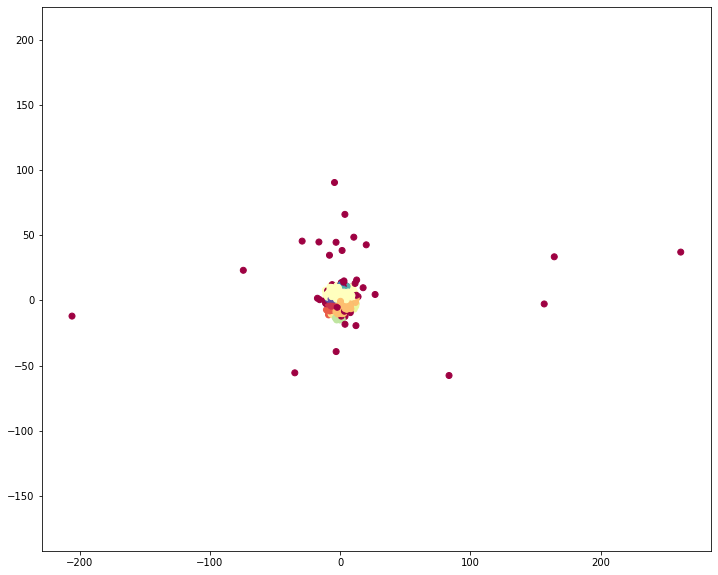

In [32]:
plt.subplots(figsize=(12, 10))
plt.axis('equal')

plt.scatter(df_tsne[0], df_tsne[1], c=df['tSNE-DBSCAN Label'], cmap = plt.cm.Spectral)

<AxesSubplot:xlabel='cluster_id', ylabel='count'>

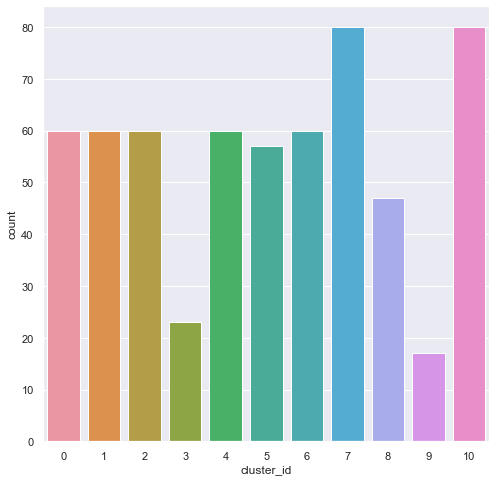

In [44]:
#Actual

sns.set(rc={'figure.figsize':(8,8)})
sns.countplot(df['cluster_id'])

<AxesSubplot:xlabel='tSNE-DBSCAN Label', ylabel='count'>

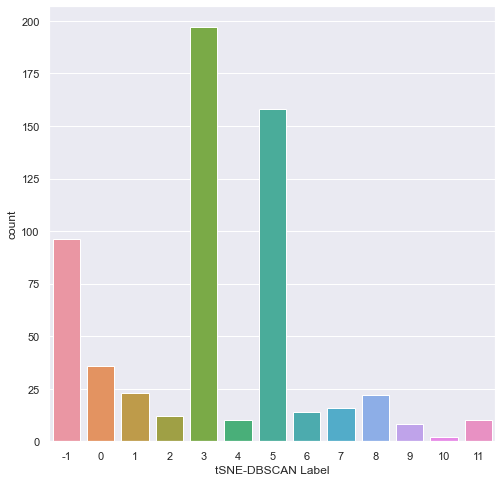

In [45]:
#Result

sns.set(rc={'figure.figsize':(8,8)})
sns.countplot(df['tSNE-DBSCAN Label'])

In [46]:
df.to_excel("output v4.xlsx")